## 98.5% of accuacy with 50 labels

## Goal

In thie programming assignment, we use an example to show how we can use autoencoders and clustering to improve classification results.

We use the mnist data set for this purpose. We are only allowed to lable 50 images from the training data set. But we are free to choose which 50 images to label.

Given this limitation, we will combine autoencoders and clustering to reach a classification accuracy above 98.5%.

## Grading Policy

This programming assignment is graded based on the achieved test accuracy. Any accuracy above 98.5% is graded as 100, whereas any accuracy below 97.5% is graded as 0. Any accuracy in between will be graded using the formula

(test_acc - 0.975)*10000

## Load the data

First, we load the mnist data and normalize the images. Note we use the last 5000 samples in the x_train_full for validation.

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


Next, we reshape the images to (28, 28, 1).

In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

We print out the first 50 training images.

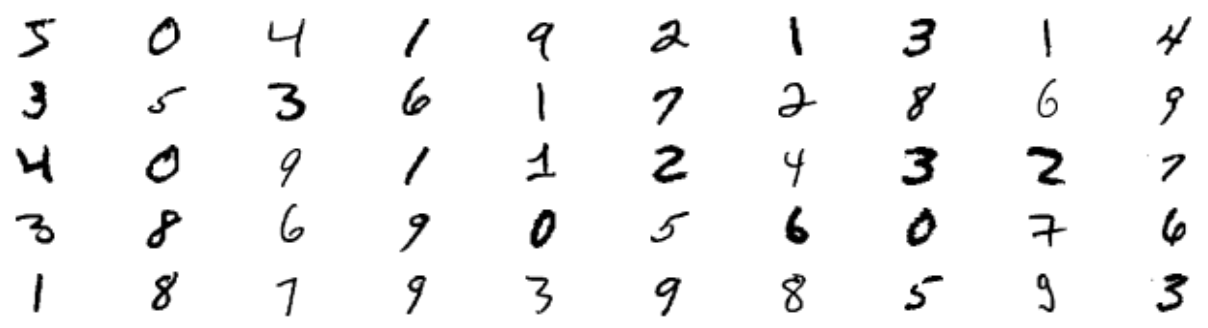

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
for index, digit in enumerate(x_train[:50]):
    plt.subplot(50 // 10, 10, index + 1)
    plt.imshow(digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

# Build  an autoencoder

First import some modules needed for this part of the code.

In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Dropout
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping

We build a autoencoder using Conv2D layers.

First, we build the encoder. Hint: study the code from this module. Try different latent_dim settings.

In [ ]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 8
layer_filters = [32, 64]

In [ ]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
x = Dropout(0.5)(x)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)


In [ ]:
# shape info needed to build decoder model

shape = K.int_shape(x)

In [ ]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 latent_vector (Dense)       (None, 8)                 25096     
                                                                 
Total params: 43912 (171.53 KB)
Trainable params: 43912 (17

Now we build the decoder. Note in the decoder we use Conv2DTranspose layers.

In [ ]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [ ]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [ ]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 8)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              28224     
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         289 

Combine the encoder and the decoder as the autocoder.

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 8)                 43912     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         83905     
                                                                 
Total params: 127817 (499.29 KB)
Trainable params: 127817 (499.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the autoencoder.

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

Train the autoencoder. Use restore_best_weights to restore the best weights.

In [ ]:

# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_valid, x_valid),
                epochs=100,
                batch_size=batch_size, callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])

Epoch 1/100
1719/1719 [==============================] - 11s 5ms/step - loss: 0.0333 - val_loss: 0.0480
Epoch 2/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0225 - val_loss: 0.0448
Epoch 3/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0210 - val_loss: 0.0457
Epoch 4/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0203 - val_loss: 0.0459
Epoch 5/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0198 - val_loss: 0.0417
Epoch 6/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0194 - val_loss: 0.0384
Epoch 7/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0190 - val_loss: 0.0393
Epoch 8/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0188 - val_loss: 0.0368
Epoch 9/100
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0185 - val_loss: 0.0372
Epoch 10/100
1719/1719 [==============================] - 8s 5ms/step - 

Plot training and validation losses during the traing.

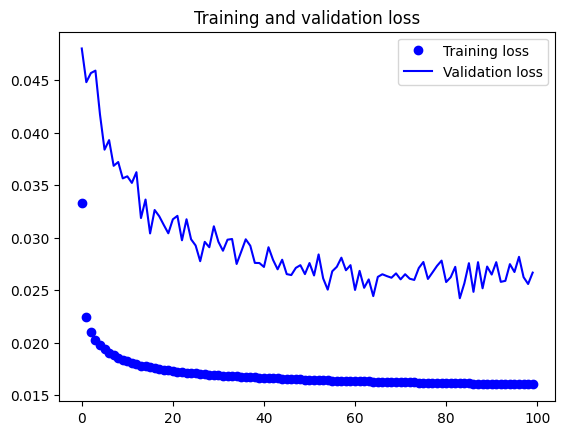

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Obtain the encoded training set and validation set.

In [ ]:
x_train_encoded = encoder.predict(x_train)
x_valid_encoded = encoder.predict(x_valid)

print(x_train_encoded.shape, x_valid_encoded.shape)

157/157 [==============================] - 0s 1ms/step
(55000, 8) (5000, 8)


## Cluster encoded training data to select 50 images for labeling

First, we use k-means to find 50 centroids of the encoded training images and label these images.

In [ ]:
from sklearn.cluster import KMeans

k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
x_digits_dist = kmeans.fit_transform(x_train_encoded)
representative_digit_idx = np.argmin(x_digits_dist, axis=0)
x_representative_digits = x_train[representative_digit_idx]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Display these 50 images.

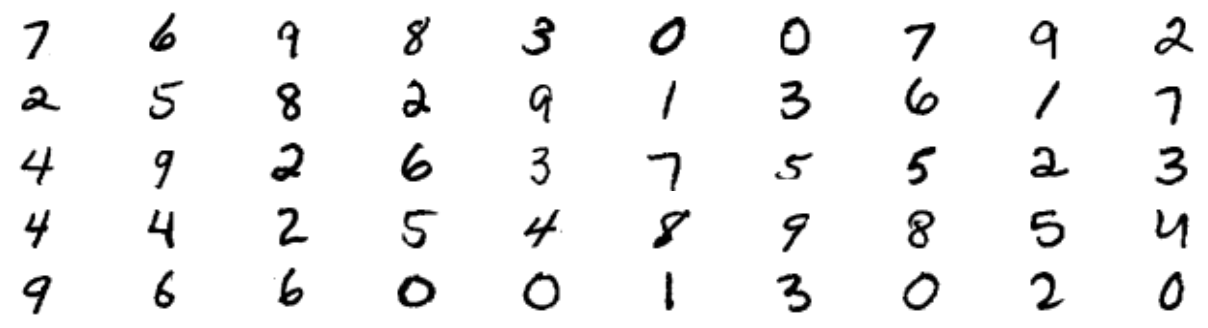

In [ ]:
plt.figure(figsize=(16, 4))
for index, x_representative_digit in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(x_representative_digit.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

Print the labels to confirm they are correct.

In [ ]:
y_representative_digits = np.empty([k])
for i, idx in enumerate(representative_digit_idx):
  y_representative_digits[i] = y_train[idx]
print(y_representative_digits)

[7. 6. 9. 8. 3. 0. 0. 7. 9. 2. 2. 5. 8. 2. 9. 1. 3. 6. 1. 7. 4. 9. 2. 6.
 3. 7. 5. 5. 2. 3. 4. 4. 2. 5. 4. 8. 9. 8. 5. 4. 9. 6. 6. 0. 0. 1. 3. 0.
 2. 0.]


In [ ]:
print(x_representative_digits.shape)
print(y_representative_digits.shape)

(50, 28, 28, 1)
(50,)


## Propagate labels and train model for classification

Propagate labels to images that are close to the 50 centroids in the latent space. Hint: study the code provied from the clustering module and try different percentile_closest values.

In [ ]:
percentile_closest = 95.007

x_cluster_dist = x_digits_dist[np.arange(len(x_train_encoded)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = x_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (x_cluster_dist > cutoff_distance)
    x_cluster_dist[in_cluster & above_cutoff] = -1

Prepare data for classification. Use images with propogated labels and save 5,000 images for validation.  

In [ ]:
partially_propagated = (x_cluster_dist != -1)
x_train_partially_propagated = x_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

In [ ]:
print(x_train_partially_propagated.shape)
print(y_train_partially_propagated.shape)

(52228, 28, 28, 1)
(52228,)


In [ ]:
x_rep_train = x_train_partially_propagated[:-5000]
y_rep_train = y_train_partially_propagated[:-5000]
x_rep_valid = x_train_partially_propagated[-5000:]
y_rep_valid = y_train_partially_propagated[-5000:]

In [ ]:
print(x_rep_train.shape, x_rep_valid.shape)

(47228, 28, 28, 1) (5000, 28, 28, 1)


In [ ]:
from keras.utils import to_categorical

train_labels = to_categorical(y_rep_train)
valid_labels = to_categorical(y_rep_valid)
test_labels = to_categorical(y_test)

Define the image classification model.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

Complie the model and train the model.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train the model. Use callbacks to restore the best model for later use.

In [ ]:
history = model.fit(x_rep_train, train_labels, validation_data=(x_rep_valid, valid_labels), epochs=100, batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)])

Epoch 1/100
1476/1476 [==============================] - 7s 4ms/step - loss: 0.2933 - accuracy: 0.9149 - val_loss: 0.1399 - val_accuracy: 0.9546
Epoch 2/100
1476/1476 [==============================] - 5s 4ms/step - loss: 0.0977 - accuracy: 0.9713 - val_loss: 0.0914 - val_accuracy: 0.9710
Epoch 3/100
1476/1476 [==============================] - 5s 4ms/step - loss: 0.0749 - accuracy: 0.9777 - val_loss: 0.0756 - val_accuracy: 0.9768
Epoch 4/100
1476/1476 [==============================] - 6s 4ms/step - loss: 0.0601 - accuracy: 0.9823 - val_loss: 0.0708 - val_accuracy: 0.9796
Epoch 5/100
1476/1476 [==============================] - 5s 4ms/step - loss: 0.0510 - accuracy: 0.9845 - val_loss: 0.0615 - val_accuracy: 0.9804
Epoch 6/100
1476/1476 [==============================] - 5s 4ms/step - loss: 0.0435 - accuracy: 0.9864 - val_loss: 0.0608 - val_accuracy: 0.9810
Epoch 7/100
1476/1476 [==============================] - 5s 4ms/step - loss: 0.0375 - accuracy: 0.9882 - val_loss: 0.0637 - val_ac

Plot the training and validation accuracies and decide whehter we need to go back to change settings or we can proceed to the final step. Note we should only run the final step once.

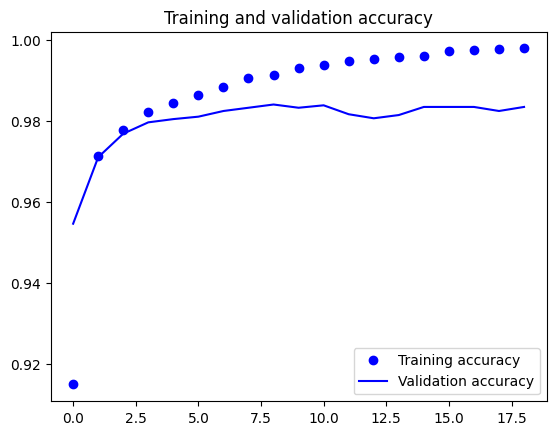

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## Final step: test accuracy and grading

Note, we should only run this step once. We should look at the validation accuracy results before this step. If we are happy with the results, we run this step. Otherwise, we adjust settings in the previous steps until we get satisfying validation accuracy results.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0431 - accuracy: 0.9858


In [ ]:
grade = max(min((test_acc - 0.975)*10000,100), 0)
print('My grade: ', grade)

My grade:  100
